# Notebook for plotting conidition number vs. number of residual points

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from tqdm import tqdm
import sys
sys.path.append('..')
from src.pyhessian import pyhessian
from src.models import PINN
from src.train_utils import *
from src.opts.adam_lbfgs import Adam_LBFGS

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


## Training the model with different number of residual points

We use a small model for an easy convection problem ($\beta = 1$).

In [ ]:
min_exp = 8
max_exp = 13
num_res_list = [2 ** exp for exp in range(min_exp, max_exp+1)]
eigval_list = []
iter_used_list = []
total_loss_list = []

initial_seed = 345
pde_name = "convection"
pde_params = ["beta", "1"]
switch_epochs = [11000]
adam_lr = 0.0001
lbfgs_history_size = 100
num_layers = 2
num_neurons = 32
loss_name = "mse"
num_x = 257
num_t = 101
num_epochs = 12500
device = "cuda:2"

for i in (progress_bar:=tqdm(range(len(num_res_list)), ncols=125)):

    num_res = num_res_list[i]

    set_random_seed(initial_seed)
    model = PINN(in_dim=2, hidden_dim=num_neurons, out_dim=1, num_layer=num_layers).to(device)
    model.apply(init_weights)

    x_range, t_range, loss_func, pde_coefs = get_pde(pde_name, pde_params, loss_name)
    x, t, data_params = get_data(x_range, t_range, num_x, num_t, random=True, num_res_samples=num_res, device=device)

    # train the model
    opt = Adam_LBFGS(model.parameters(), switch_epochs=switch_epochs, adam_params={"lr": adam_lr}, lbfgs_params={"history_size": lbfgs_history_size, "line_search_fn": "strong_wolfe"})

    loss_hist = []
    loss_res_hist = []
    loss_bc_hist = []
    loss_ic_hist = []

    for j in range(num_epochs):
        model.train()
        def closure():
            opt.zero_grad()
            outputs = predict(x, t, model)
            loss_res, loss_bc, loss_ic = loss_func(x, t, outputs)
            loss = loss_res + loss_bc + loss_ic
            loss.backward()

            return loss

        opt.step(closure)

        model.eval()
        loss_res, loss_bc, loss_ic = loss_func(x, t, predict(x, t, model))
        loss = loss_res + loss_bc + loss_ic

        loss_hist.append(loss.item())
        loss_res_hist.append(loss_res.item())
        loss_bc_hist.append(loss_bc.item())
        loss_ic_hist.append(loss_ic.item())

        progress_bar.set_postfix_str("{} out of {} / res {:.2e} / bc {:.2e} / ic {:.2e} / total {:.2e}".format(j, num_epochs, loss_res_hist[-1], loss_bc_hist[-1], loss_ic_hist[-1], loss_hist[-1]))

    total_loss_list.append(loss_hist)

    # compute eigenvalues
    hessian_comp = hessian(model, predict, loss_func, data=(x,t), device=device)
    eigenvalues, _, iter_used = hessian_comp.eigenvalues(max_num_iter=500, top_n=129)
    eigval_list.append(np.array(eigenvalues))
    iter_used_list.append(np.array(iter_used))

torch.save({
            'num_res_list': num_res_list,
            'eigval_list': eigval_list,
            'iter_used_list': iter_used_list,
            'total_loss_list': total_loss_list
            }, "eigenvalues_convection")

## Making the plot

In [ ]:
def get_title(pde_name, pde_params):
  if pde_name == "convection":
    return f'Convection, $\\beta = {pde_params[1]}$'
  if pde_name == "reaction":
    return f'Reaction, $\\rho = {pde_params[1]}$'
  elif pde_name == "wave":
    return f'Wave, $\\beta = {pde_params[1]}$'

In [ ]:
# load saved results
pdes = [('convection', ['beta', '1'])]
saved_results = {'convection': torch.load('eigenvalues_convection', map_location=torch.device('cpu'))}

# make sure texts are rendered in serif via LaTex
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [ ]:
def plot_condition_number(pdes, saved_results, font_size, folder_path, filename):
  mpl.rcParams.update({'font.size': font_size})

  nrows = 1
  ncols = len(pdes)

  fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))

  for col, (pde_name, pde_params) in enumerate(pdes):
    pde_result = saved_results[pde_name]

    num_res_list = pde_result['num_res_list']
    condition_number_list = [np.abs(eigenvalues[0]/eigenvalues[-1]) for eigenvalues in pde_result['eigval_list']]

    if ncols == 1:
      ax = axs
    else:
      ax = axs[col]
    ax.semilogy(np.log2(num_res_list), condition_number_list)

    ax.set_ylabel('$\\lambda_1 / \\lambda_{129}$')
    ax.set_xlabel('$\\log_2 n_{\\mathrm{res}}$')
    ax.set_title(get_title(pde_name, pde_params))

  fig.tight_layout(rect=[0, 0.03, 1, 0.95])

  if not os.path.exists(folder_path):
    os.makedirs(folder_path)

  filename = filename + '.pdf'
  fig.savefig(os.path.join(folder_path, filename), bbox_inches='tight')
  plt.show()

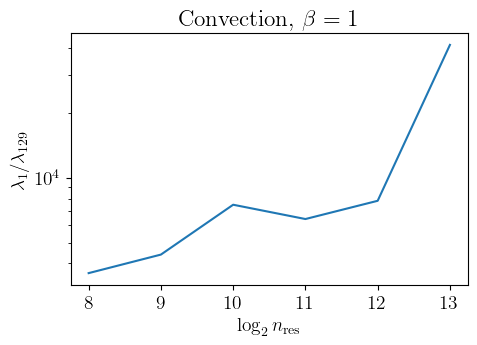

In [ ]:
plot_condition_number(pdes, saved_results, font_size=14, folder_path='condition_number_bound', filename='condition_number_bound')